<a href="https://colab.research.google.com/github/austin-codd/FDA-Drug-Recall-Severity-Prediction/blob/main/Drugs_Recall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import requests
import pandas as pd
import numpy as np
import json
import os
import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [100]:
def fetch_fda_data(num_records=17100):
    all_results = []
    limit = 100
    pages = (num_records + limit - 1) // limit

    for i in range(pages):
        skip = i * limit
        api_url = f"https://api.fda.gov/drug/enforcement.json?search=report_date:[20150101+TO+20250101]&limit={limit}&skip={skip}"

        response = requests.get(api_url)
        if response.status_code == 200:
          data = response.json()
          results = data.get('results', [])
        if not results:
          break
        all_results.extend(results)
        time.sleep(0.2)

    return pd.json_normalize(all_results)

In [101]:
df_raw = fetch_fda_data()

In [102]:
df_raw.shape

(15072, 45)

In [103]:
df=df_raw.copy()

/tmp/ipython-input-2689567324.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='classification', data=df, order=['Class I', 'Class II', 'Class III'], palette='viridis')


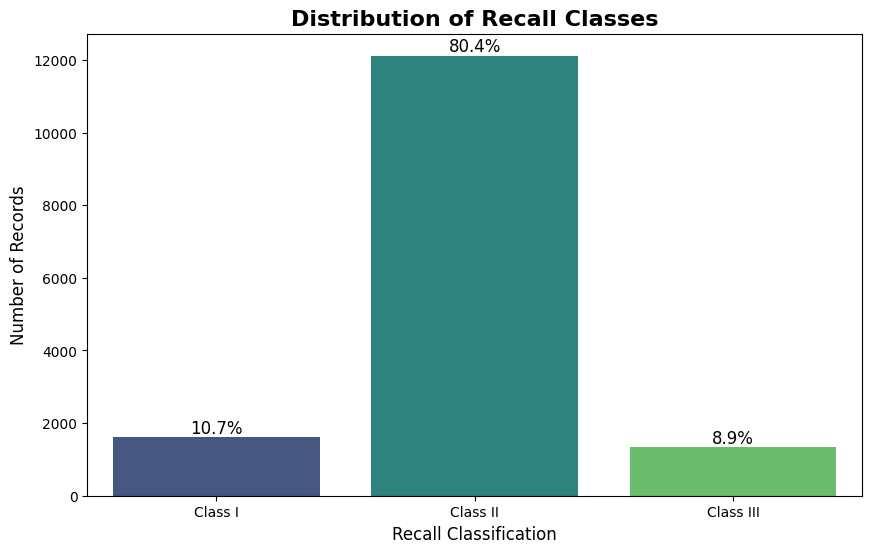

In [104]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='classification', data=df, order=['Class I', 'Class II', 'Class III'], palette='viridis')
plt.title('Distribution of Recall Classes', fontsize=16, fontweight='bold')
plt.xlabel('Recall Classification', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

We can see that the data is heavily imbalanced. Therefore, any successful modeling strategy must explicitly account for this severe imbalance.

In [105]:
df['classification'].value_counts()

,count
classification,
Class II,12115
Class I,1614
Class III,1343


In [106]:
df['voluntary_mandated']=df['voluntary_mandated'].replace(['N/A',''],'Not Specified')

In [107]:
df.head(1)

,status,city,state,country,classification,product_type,event_id,recalling_firm,address_1,address_2,...,openfda.is_original_packager,openfda.unii,more_code_info,openfda.upc,openfda.nui,openfda.pharm_class_moa,openfda.pharm_class_epc,openfda.pharm_class_cs,openfda.original_packager_product_ndc,openfda.pharm_class_pe
0,Terminated,Peoria,IL,United States,Class II,Drugs,72241,"Kalman Health & Wellness, Inc. dba Essential W...",4625 N University St,N/A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
df.columns

Index(['status', 'city', 'state', 'country', 'classification', 'product_type',
       'event_id', 'recalling_firm', 'address_1', 'address_2', 'postal_code',
       'voluntary_mandated', 'initial_firm_notification',
       'distribution_pattern', 'recall_number', 'product_description',
       'product_quantity', 'reason_for_recall', 'recall_initiation_date',
       'center_classification_date', 'termination_date', 'report_date',
       'code_info', 'openfda.application_number', 'openfda.brand_name',
       'openfda.generic_name', 'openfda.manufacturer_name',
       'openfda.product_ndc', 'openfda.product_type', 'openfda.route',
       'openfda.substance_name', 'openfda.rxcui', 'openfda.spl_id',
       'openfda.spl_set_id', 'openfda.package_ndc',
       'openfda.is_original_packager', 'openfda.unii', 'more_code_info',
       'openfda.upc', 'openfda.nui', 'openfda.pharm_class_moa',
       'openfda.pharm_class_epc', 'openfda.pharm_class_cs',
       'openfda.original_packager_product_ndc', 

In [109]:
cols= ['recall_number', 'event_id',
                'more_code_info', 'termination_date','address_1', 'address_2', 'postal_code', 'code_info',
                'product_description', 'product_quantity','initial_firm_notification',
       'termination_date',
       'code_info', 'openfda.application_number', 'openfda.brand_name',
       'openfda.generic_name', 'openfda.manufacturer_name',
       'openfda.product_ndc', 'openfda.product_type', 'openfda.route',
       'openfda.substance_name', 'openfda.rxcui', 'openfda.spl_id',
       'openfda.spl_set_id', 'openfda.package_ndc',
       'openfda.is_original_packager', 'openfda.unii', 'more_code_info',
       'openfda.upc', 'openfda.nui', 'openfda.pharm_class_moa',
       'openfda.pharm_class_epc', 'openfda.pharm_class_cs',
       'openfda.original_packager_product_ndc', 'openfda.pharm_class_pe']
df = df.drop(columns=cols)

In [110]:
date_cols = ['report_date', 'recall_initiation_date', 'center_classification_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%Y%m%d', errors='coerce')


In [111]:
original_rows = len(df)
df.dropna(subset=date_cols, inplace=True)

In [112]:
text_cols = ['reason_for_recall', 'recalling_firm', 'city', 'state', 'distribution_pattern']
for col in text_cols:
    df[col] = df[col].str.lower().str.strip()

In [113]:
df['reason_for_recall'].fillna('not specified', inplace=True)


/tmp/ipython-input-3073862814.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reason_for_recall'].fillna('not specified', inplace=True)


In [114]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['classification'] = le.fit_transform(df['classification'])

In [115]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
column_to_encode = df[['voluntary_mandated']]
encoded_data = encoder.fit_transform(column_to_encode)
new_column_names = encoder.get_feature_names_out(['voluntary_mandated'])
df_encoded_sklearn = pd.DataFrame(encoded_data, columns=new_column_names)


In [116]:
df = df.drop('voluntary_mandated', axis=1).join(df_encoded_sklearn)


In [117]:
df.head()

,status,city,state,country,classification,product_type,recalling_firm,distribution_pattern,reason_for_recall,recall_initiation_date,center_classification_date,report_date,voluntary_mandated_Not Specified,voluntary_mandated_Voluntary: Firm initiated
0,Terminated,peoria,il,United States,1,Drugs,"kalman health & wellness, inc. dba essential w...",nationwide,lack of assurance of sterility: a recall of a...,2015-09-03,2015-11-17,2015-11-25,0.0,1.0
1,Ongoing,san juan del rio,n/a,Mexico,1,Drugs,albek de mexico s.a. de c.v.,usa nationwide,cgmp deviations: next advanced antibacterial h...,2020-07-30,2020-11-17,2020-11-25,0.0,1.0
2,Terminated,parsippany,nj,United States,1,Drugs,teva pharmaceuticals usa,nationwide within the united state and puerto ...,some bottles may contain mixed strengths of th...,2020-05-22,2020-06-04,2020-06-10,0.0,1.0
3,Terminated,allegan,mi,United States,1,Drugs,perrigo company plc,nationwide in the usa,cgmp deviations: products were manufactured wi...,2021-10-26,2022-02-23,2022-03-02,0.0,1.0
4,Terminated,lake forest,il,United States,1,Drugs,"pharmedium services, llc",nationwide,presence of particulate matter: api contaminat...,2016-05-05,2016-07-16,2016-07-27,0.0,1.0


In [118]:
df['classification'].value_counts() # Class I- 0, class II-1 and class III-2

,count
classification,
1,12115
0,1614
2,1343


In [119]:
df.shape

(15072, 14)

In [120]:
df.head()

,status,city,state,country,classification,product_type,recalling_firm,distribution_pattern,reason_for_recall,recall_initiation_date,center_classification_date,report_date,voluntary_mandated_Not Specified,voluntary_mandated_Voluntary: Firm initiated
0,Terminated,peoria,il,United States,1,Drugs,"kalman health & wellness, inc. dba essential w...",nationwide,lack of assurance of sterility: a recall of a...,2015-09-03,2015-11-17,2015-11-25,0.0,1.0
1,Ongoing,san juan del rio,n/a,Mexico,1,Drugs,albek de mexico s.a. de c.v.,usa nationwide,cgmp deviations: next advanced antibacterial h...,2020-07-30,2020-11-17,2020-11-25,0.0,1.0
2,Terminated,parsippany,nj,United States,1,Drugs,teva pharmaceuticals usa,nationwide within the united state and puerto ...,some bottles may contain mixed strengths of th...,2020-05-22,2020-06-04,2020-06-10,0.0,1.0
3,Terminated,allegan,mi,United States,1,Drugs,perrigo company plc,nationwide in the usa,cgmp deviations: products were manufactured wi...,2021-10-26,2022-02-23,2022-03-02,0.0,1.0
4,Terminated,lake forest,il,United States,1,Drugs,"pharmedium services, llc",nationwide,presence of particulate matter: api contaminat...,2016-05-05,2016-07-16,2016-07-27,0.0,1.0


<Figure size 1400x700 with 0 Axes>

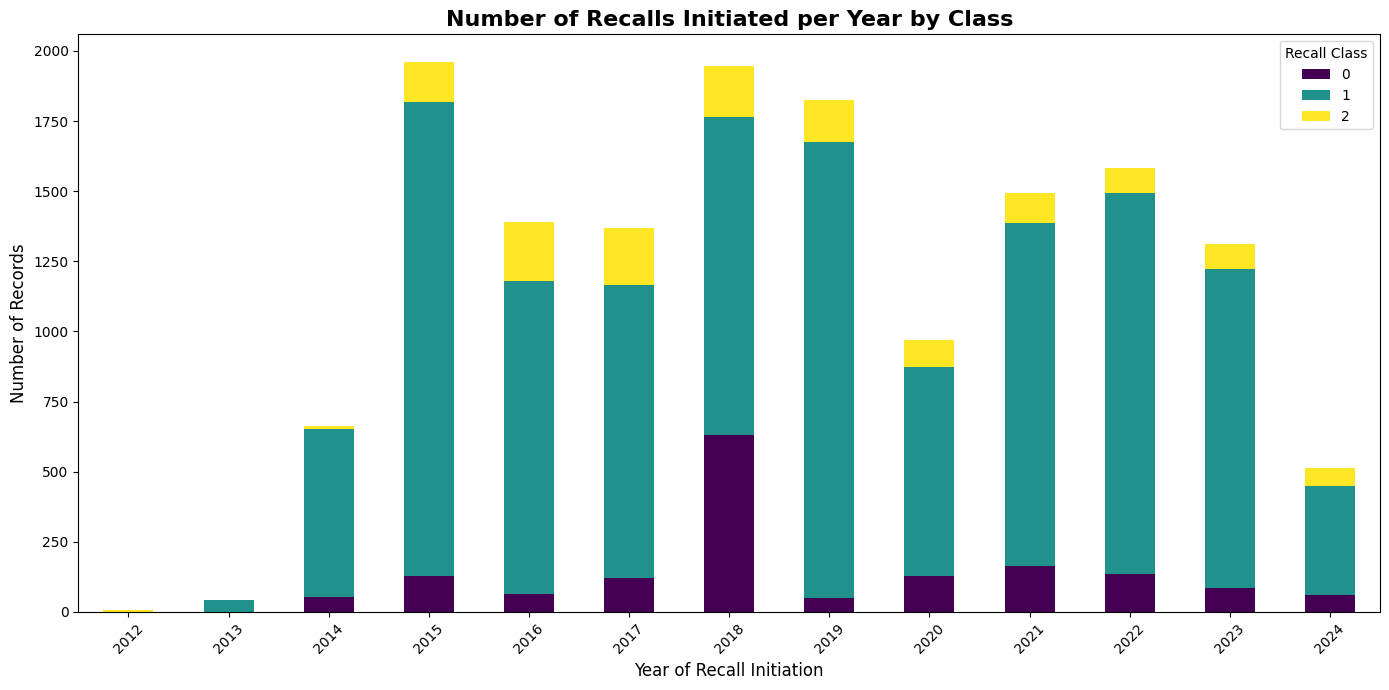

In [121]:
plt.figure(figsize=(14, 7))
df.groupby([df['recall_initiation_date'].dt.year, 'classification'])['classification'].count().unstack().plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Number of Recalls Initiated per Year by Class', fontsize=16, fontweight='bold')
plt.xlabel('Year of Recall Initiation', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Recall Class')
plt.tight_layout()
plt.show()

In [122]:
# extracting temporal features
df['reporting_lag_days'] = (df['report_date'] - df['recall_initiation_date']).dt.days
df['classification_lag_days'] = (df['center_classification_date'] - df['recall_initiation_date']).dt.days


In [123]:
# making sure that any lag is not negative
df['reporting_lag_days'] = df['reporting_lag_days'].apply(lambda x: max(x, 0))
df['classification_lag_days'] = df['classification_lag_days'].apply(lambda x: max(x, 0))


In [124]:
df['report_year'] = df['report_date'].dt.year
df['report_month'] = df['report_date'].dt.month
df['report_day_of_week'] = df['report_date'].dt.dayofweek # Monday=0, Sunday=6


# Using simple NLP

In [125]:
# defining the keywords that may indicate the severity
keywords = {
    'sterility': ['sterile', 'sterility', 'non-sterile'],
    'contamination': ['contaminant', 'contamination', 'contaminated', 'foreign', 'particulate', 'glass', 'metal'],
    'potency': ['potent', 'potency', 'subpotent', 'superpotent'],
    'labeling': ['label', 'labeling', 'mislabel'],
    'cgmp': ['cgmp', 'good manufacturing practice'],
    'specification': ['oos', 'out of specification', 'failed spec'],
    'stability': ['stability']
}

In [126]:
# creating binary features out of the severity keywords
for feature_name, k_list in keywords.items():
    # Create a regex pattern to find any of the keywords in the list
    pattern = '|'.join(k_list)
    df[f'has_{feature_name}_keyword'] = df['reason_for_recall'].str.contains(pattern, case=False, regex=True).astype(int)


In [127]:
keyword_counts = df[[f'has_{k}_keyword' for k in keywords.keys()]].sum().sort_values(ascending=False)
keyword_counts

,0
has_sterility_keyword,5666
has_cgmp_keyword,3515
has_contamination_keyword,2923
has_potency_keyword,2564
has_stability_keyword,1023
has_labeling_keyword,999
has_specification_keyword,805


In [128]:
firm_counts = df['recalling_firm'].map(df['recalling_firm'].value_counts())
df['firm_recall_count'] = firm_counts

# Advanced Feature engineering

In [129]:
df['is_class_I'] = (df['classification'] == 'Class I').astype(int)
firm_groups = df.groupby('recalling_firm')
firm_stats = firm_groups.agg(
    # Ratio of Class I recalls for the firm
    firm_class_I_ratio=('is_class_I', 'mean'),

    # Average reporting lag for the firm
    firm_avg_reporting_lag=('reporting_lag_days', 'mean'),

    # Ratio of recalls related to sterility for the firm
    firm_sterility_recall_ratio=('has_sterility_keyword', 'mean')
)

In [130]:
df = df.merge(firm_stats, on='recalling_firm', how='left')

In [131]:
df.columns

Index(['status', 'city', 'state', 'country', 'classification', 'product_type',
       'recalling_firm', 'distribution_pattern', 'reason_for_recall',
       'recall_initiation_date', 'center_classification_date', 'report_date',
       'voluntary_mandated_Not Specified',
       'voluntary_mandated_Voluntary: Firm initiated', 'reporting_lag_days',
       'classification_lag_days', 'report_year', 'report_month',
       'report_day_of_week', 'has_sterility_keyword',
       'has_contamination_keyword', 'has_potency_keyword',
       'has_labeling_keyword', 'has_cgmp_keyword', 'has_specification_keyword',
       'has_stability_keyword', 'firm_recall_count', 'is_class_I',
       'firm_class_I_ratio', 'firm_avg_reporting_lag',
       'firm_sterility_recall_ratio'],
      dtype='object')

In [132]:
numerical_features = [
    'reporting_lag_days', 'classification_lag_days', 'firm_recall_count',
    'firm_avg_reporting_lag', 'firm_sterility_recall_ratio','firm_avg_reporting_lag_x',
       'firm_sterility_recall_ratio_x', 'firm_avg_reporting_lag_y',
       'firm_sterility_recall_ratio_y'
]
keyword_features = [col for col in df.columns if 'has_' in col]
categorical_features = ['voluntary_mandated','classification']

In [133]:
all_features = numerical_features + keyword_features + categorical_features
all_features

['reporting_lag_days',
 'classification_lag_days',
 'firm_recall_count',
 'firm_avg_reporting_lag',
 'firm_sterility_recall_ratio',
 'firm_avg_reporting_lag_x',
 'firm_sterility_recall_ratio_x',
 'firm_avg_reporting_lag_y',
 'firm_sterility_recall_ratio_y',
 'has_sterility_keyword',
 'has_contamination_keyword',
 'has_potency_keyword',
 'has_labeling_keyword',
 'has_cgmp_keyword',
 'has_specification_keyword',
 'has_stability_keyword',
 'voluntary_mandated',
 'classification']

In [134]:
X=df.drop(columns=['classification','status','state','country','product_type','distribution_pattern','reason_for_recall','recalling_firm','reason_for_recall',
       'recall_initiation_date', 'center_classification_date','is_class_I','city','report_date','report_year','report_month','report_day_of_week'])
y=df['classification']

In [135]:
X.columns

Index(['voluntary_mandated_Not Specified',
       'voluntary_mandated_Voluntary: Firm initiated', 'reporting_lag_days',
       'classification_lag_days', 'has_sterility_keyword',
       'has_contamination_keyword', 'has_potency_keyword',
       'has_labeling_keyword', 'has_cgmp_keyword', 'has_specification_keyword',
       'has_stability_keyword', 'firm_recall_count', 'firm_class_I_ratio',
       'firm_avg_reporting_lag', 'firm_sterility_recall_ratio'],
      dtype='object')

In [136]:
X.head()

,voluntary_mandated_Not Specified,voluntary_mandated_Voluntary: Firm initiated,reporting_lag_days,classification_lag_days,has_sterility_keyword,has_contamination_keyword,has_potency_keyword,has_labeling_keyword,has_cgmp_keyword,has_specification_keyword,has_stability_keyword,firm_recall_count,firm_class_I_ratio,firm_avg_reporting_lag,firm_sterility_recall_ratio
0,0.0,1.0,83,75,1,0,0,0,0,0,0,39,0.0,83.000000,1.000000
1,0.0,1.0,118,110,0,0,0,1,1,0,0,5,0.0,118.000000,0.000000
2,0.0,1.0,19,13,0,0,0,0,0,0,0,239,0.0,26.949791,0.334728
3,0.0,1.0,127,120,0,1,0,0,1,0,0,104,0.0,138.173077,0.000000
4,0.0,1.0,83,72,1,1,0,0,0,0,0,358,0.0,234.581006,0.413408


In [137]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [138]:
y_train.value_counts(normalize=True)*100

,proportion
classification,
1,80.379147
0,10.710900
2,8.909953


In [139]:
y_test.value_counts(normalize=True)*100

,proportion
classification,
1,80.384785
0,10.703229
2,8.911986


# Building a Pre-processing pipeline

In [140]:
numeric_and_keyword_features = numerical_features + keyword_features
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric_and_keyword_features)],
    remainder='passthrough' # Use 'passthrough' to keep other columns or 'drop' to remove them
)

In [141]:
X_train.head()

,voluntary_mandated_Not Specified,voluntary_mandated_Voluntary: Firm initiated,reporting_lag_days,classification_lag_days,has_sterility_keyword,has_contamination_keyword,has_potency_keyword,has_labeling_keyword,has_cgmp_keyword,has_specification_keyword,has_stability_keyword,firm_recall_count,firm_class_I_ratio,firm_avg_reporting_lag,firm_sterility_recall_ratio
6658,0.0,1.0,97,85,1,0,0,0,0,0,1,65,0.0,97.000000,1.00000
14693,0.0,1.0,69,60,0,0,0,0,1,0,0,231,0.0,66.008658,0.00000
7034,0.0,1.0,139,136,0,0,1,1,0,0,0,113,0.0,134.938053,0.00885
4079,0.0,1.0,243,231,0,1,0,0,0,0,0,541,0.0,243.000000,0.00000
8775,0.0,1.0,13,14,0,0,0,0,1,0,0,25,0.0,89.360000,0.00000


# Creating a model pipeline

In [142]:
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fitting a Logistic Regression

In [143]:
from sklearn.linear_model import LogisticRegression

In [144]:
lr=LogisticRegression()
mod_lr=lr.fit(X_train,y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [145]:
ypred1=mod_lr.predict(X_test)

In [146]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

In [147]:
accuracy_score(ypred1,y_test)

0.8348076072534277

In [148]:
print(classification_report(ypred1,y_test))

              precision    recall  f1-score   support

           0       0.35      0.82      0.49       204
           1       0.99      0.84      0.91      4318
           2       0.00      0.00      0.00         0

    accuracy                           0.83      4522
   macro avg       0.45      0.55      0.46      4522
weighted avg       0.96      0.83      0.89      4522



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Fitting a Decision Tree

In [149]:
from sklearn.tree import DecisionTreeClassifier

In [150]:
dt=DecisionTreeClassifier(max_depth=50,min_samples_split=200,min_samples_leaf=500)
mod_dt=dt.fit(X_train,y_train)
ypred2=mod_dt.predict(X_test)
accuracy_score(ypred2,y_test)

0.8301636444051305

In [151]:
print(classification_report(ypred2,y_test))

              precision    recall  f1-score   support

           0       0.35      0.75      0.47       225
           1       0.99      0.83      0.90      4297
           2       0.00      0.00      0.00         0

    accuracy                           0.83      4522
   macro avg       0.44      0.53      0.46      4522
weighted avg       0.95      0.83      0.88      4522



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Fitting Random Forest

In [152]:
from sklearn.ensemble import RandomForestClassifier

In [153]:
rf=RandomForestClassifier()
mod_rf=rf.fit(X_train,y_train)
ypred3=mod_rf.predict(X_test)
accuracy_score(ypred3,y_test)

0.9323308270676691

In [154]:
print(classification_report(ypred3,y_test))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       465
           1       0.97      0.96      0.96      3680
           2       0.67      0.72      0.69       377

    accuracy                           0.93      4522
   macro avg       0.84      0.86      0.85      4522
weighted avg       0.93      0.93      0.93      4522



# Applying SMOTE

In [155]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [156]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [157]:
from imblearn.over_sampling import SMOTENC

categorical_feature_indices = [0, 1]

smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)

X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

mod_rf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier()

In [158]:
ypred5=mod_rf.predict(X_test)
accuracy_score(ypred5,y_test)

0.9175143741707209

In [159]:
print(classification_report(ypred5,y_test))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       508
           1       0.94      0.97      0.95      3534
           2       0.73      0.62      0.67       480

    accuracy                           0.92      4522
   macro avg       0.85      0.82      0.83      4522
weighted avg       0.91      0.92      0.92      4522



In [160]:
mod_rf.fit(X_train_resampled,y_train_resampled)
ypred5=mod_rf.predict(X_test)
accuracy_score(ypred5,y_test)

0.9164086687306502

In [161]:
from sklearn.model_selection import cross_val_score

In [162]:
cross_val_score(mod_rf,X,y,cv=5).mean()

np.float64(0.9210455354283658)

# Using Stratified K Folds to combat Imbalanced Data

In [163]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [164]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [165]:
y = pd.DataFrame(df, columns=['classification'])

In [166]:
f1_scores = cross_val_score(mod_rf, X, y, cv=cv_strategy, scoring='f1_weighted', n_jobs=-1)

In [167]:
recall_scores = cross_val_score(mod_rf, X, y, cv=cv_strategy, scoring='recall_weighted', n_jobs=-1)
recall_scores.mean()

np.float64(0.9349790749856115)

In [168]:
f1_scores.mean()

np.float64(0.9323871705465805)

Therefore after using the RandomForest Classifier we get the best results with F1 score being 93% and recall being 93%

# Graphically representing the Random Forest

In [169]:
from sklearn.tree import plot_tree

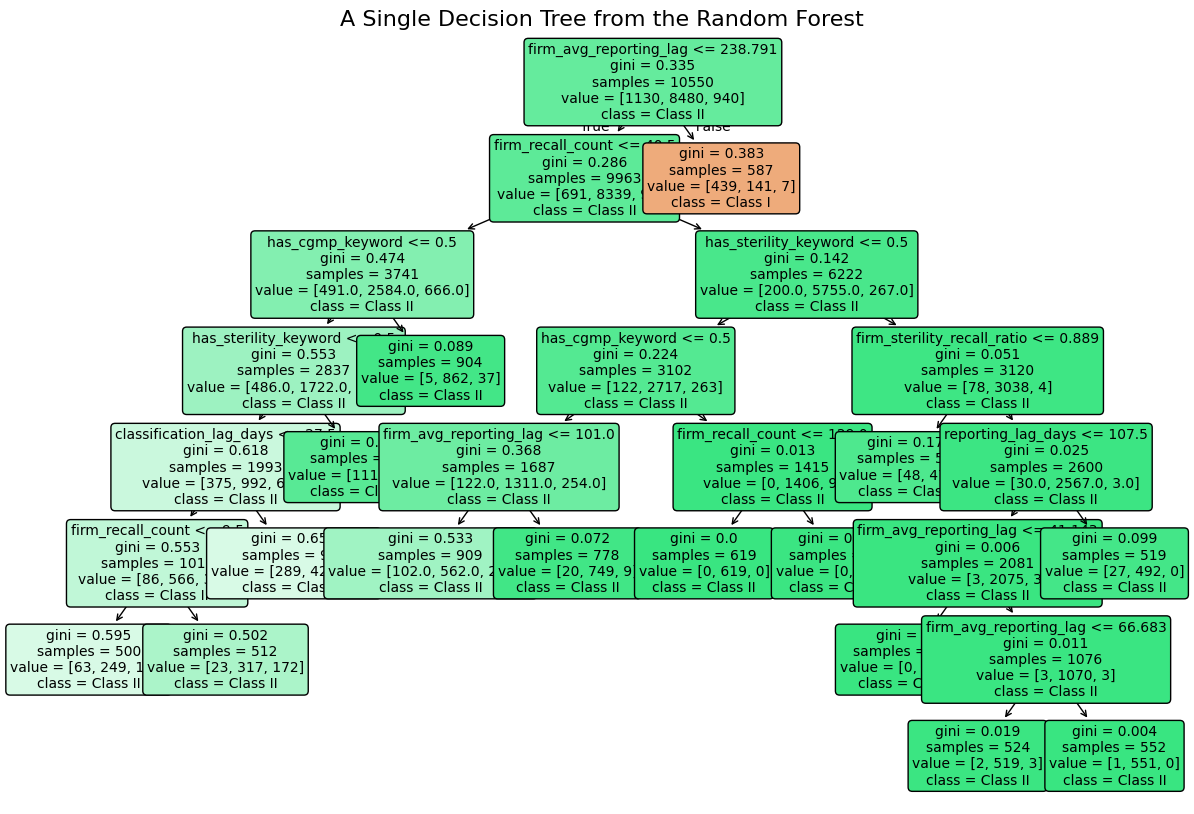

In [170]:
plt.figure(figsize=(15, 10))
plot_tree(
    mod_dt,
    feature_names=X.columns.tolist(),
    class_names=['Class I', 'Class II','Class III'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("A Single Decision Tree from the Random Forest", fontsize=16)
plt.show()

# Optimising the Random Forest using Optuna

In [171]:
! pip install optuna

In [172]:
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

feature_columns = [
    'voluntary_mandated_Not Specified',
    'voluntary_mandated_Voluntary: Firm initiated', 'reporting_lag_days',
    'classification_lag_days', 'has_sterility_keyword',
    'has_contamination_keyword', 'has_potency_keyword',
    'has_labeling_keyword', 'has_cgmp_keyword', 'has_specification_keyword',
    'has_stability_keyword', 'firm_recall_count', 'firm_class_I_ratio',
    'firm_avg_reporting_lag', 'firm_sterility_recall_ratio'
]
X = df[feature_columns]

y = df['classification']


def find_best_settings(trial):
    number_of_trees = trial.suggest_int('n_estimators', 100, 1000)
    tree_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_for_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_in_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    how_to_weight_classes = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])

    random_forest = RandomForestClassifier(
        n_estimators=number_of_trees,
        max_depth=tree_depth,
        min_samples_split=min_samples_for_split,
        min_samples_leaf=min_samples_in_leaf,
        class_weight=how_to_weight_classes,
        random_state=42  # For repeatable results
    )

    five_fold_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    all_scores = cross_val_score(random_forest, X, y, cv=five_fold_validation, scoring='f1_weighted')

    return all_scores.mean()


search_for_best_model = optuna.create_study(direction='maximize')

search_for_best_model.optimize(find_best_settings, n_trials=50)

best_settings = search_for_best_model.best_params
best_score = search_for_best_model.best_value

print(f"\n Best F1-Score Achieved: {best_score:.4f}")
print("Found the best settings:")

for setting, value in best_settings.items():
    print(f"  - {setting}: {value}")

final_optimized_model = RandomForestClassifier(**best_settings, random_state=42)
print("\nFinal optimized model is ready to be trained and used.")

[I 2025-10-05 03:57:48,968] A new study created in memory with name: no-name-be51a802-6bfe-4b18-b2cb-23f850e506f6
[I 2025-10-05 03:58:23,224] Trial 0 finished with value: 0.8567643183395519 and parameters: {'n_estimators': 707, 'max_depth': 27, 'min_samples_split': 24, 'min_samples_leaf': 27, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8567643183395519.
[I 2025-10-05 03:58:58,065] Trial 1 finished with value: 0.8539401684721138 and parameters: {'n_estimators': 727, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 28, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.8567643183395519.
[I 2025-10-05 03:59:35,488] Trial 2 finished with value: 0.8599775136479634 and parameters: {'n_estimators': 706, 'max_depth': 42, 'min_samples_split': 25, 'min_samples_leaf': 20, 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.8599775136479634.
[I 2025-10-05 04:00:03,198] Trial 3 finished with value: 0.8812527379228335 and parameters: {'n


 Best F1-Score Achieved: 0.9186
Found the best settings:
  - n_estimators: 999
  - max_depth: 44
  - min_samples_split: 6
  - min_samples_leaf: 2
  - class_weight: balanced

Final optimized model is ready to be trained and used.


# Training the optimised Random Forest Classifier

In [175]:
rf=RandomForestClassifier(999,max_depth=44,min_samples_split=6,min_samples_leaf=2,class_weight='balanced')
mod_rf=rf.fit(X_train,y_train)
ypred3=mod_rf.predict(X_test)

In [176]:
print(classification_report(ypred3,y_test))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       546
           1       0.92      0.98      0.95      3415
           2       0.82      0.59      0.69       561

    accuracy                           0.91      4522
   macro avg       0.88      0.80      0.83      4522
weighted avg       0.91      0.91      0.91      4522

